# COMS6998 Final Report
Liushiya Chen $\quad$ Peimou Sun

In [2]:
PACKAGE_PATH = "F:\PSun-dev\Python\mlpp_project"  # <- Update path
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys
import time
sys.path.append(PACKAGE_PATH)
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import torch
from pyro.optim import ClippedAdam
import pyro.distributions as dist
from ldavi.bbvi import LDABBVI
from ldavi.cavi import LDACAVI
from util import load_process, run_mc_experiment

## 1. Problem statement and data description

### 1.1 Problem statement

* Our first goal is to apply LDA to a domain outside of language processing.
* Our second goal is to see if BBVI can be a good alternative to the more proven and model-specific CAVI.

### 1.2 Data description

We are using Instacart order data with 1,384,617 records of purchased products. The data set consists of orders which are collections of products.

We did some light preprocessing to remove generic words and detailed descriptions, e.g. "Mexican Big Green Organic Avocados" to "Organic Avocados"

In [3]:
order, data, vocab = load_process(nrows=200)
data_series = pd.Series(data)
pd.set_option('display.max_colwidth', 60)
pd.DataFrame(data_series.rename('products')).head(5)

,products
0,"[spring water, calcium vitamin, bean yogurt, organic ban..."
1,"[salad dressing, seedless grapes, organic bananas, chopp..."
2,"[irish butter, almond milk, breakfast sausage, sunday ba..."
3,"[organic strawberries, genoa salami, baby carrots, corn ..."
4,"[banana, vanilla yogurt, honeycrisp apple, baby spinach,..."


In [5]:
corpora = list(vocab)
split_ = int(0.9 * len(data))
train_data = data[:split_]
valid_data = data[split_:]

## 2. LDA model

For the sake of conciseness, we will simply provide the plate notation of LDA's data generation process:

<img src="img/Smoothed_LDA.png" style="width: 300px;">

## 3. Inference

We want to use mean-field VI to approximate the posterior distribution for latent variables $(\theta, \mathbf{Z})$.

$ p(\mathbf{\theta}, \mathbf{Z}| \mathbf{P}, \alpha, \beta) = \prod\limits_{i = 1}^{O}\frac{p(\theta_i, \mathbf{z_i}, \mathbf{p_i}| \alpha, \beta)}{p(\mathbf{p_i} | \alpha, \beta)} $


, where $\mathbf{z}_i$ denotes the topics vector and $\mathbf{p}_i$ denotes the products vector for the $i$th order.

The predictive probability (defined below) can be approximated with MC integration. Note that we use the variational distributions over the latent variables, $q(z, \theta | \phi, \gamma)$.
$$p(w) \approx \int_{z,\theta} p(w, z, \theta) dzd\theta = \int_{z,\theta} p(w| z, \theta) q(z, \theta | \phi, \gamma)dzd\theta \approx \frac{1}{S}\sum_{i=1}^S p(w | z_i, \theta_i)$$

### 3.1 BBVI

Here are the results for BBVIL

In [ ]:
n_topics = 5
opt_params = {"lr": 0.005, "betas": (0.95, 0.999)}
n_steps = 1000 # must be more than 20 steps
n_particles = 1

st = time.time()
bbvi_obj = LDABBVI(train_data, list(vocab), 
                   valid_data, ClippedAdam, opt_params,
                   n_topics)
e_eblo, log_prob, valid_prob = bbvi_obj.run_svi(
    n_steps=n_steps, num_particles=n_particles)
print(f"Takes {time.time() - st} seconds")

(1.0, 1000.0)

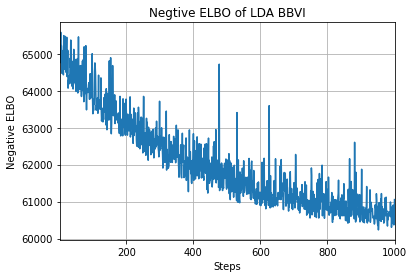

In [6]:
plt.plot(np.linspace(1, len(e_eblo), len(e_eblo)), e_eblo)
plt.title("Negtive ELBO of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Negative ELBO")
plt.grid()
plt.xlim((1, len(e_eblo)))

(1.0, 1000.0)

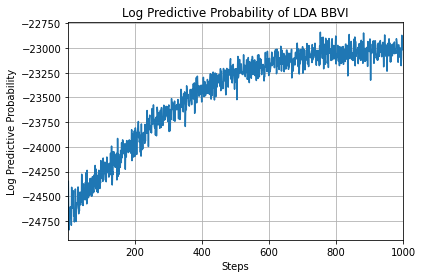

In [7]:
plt.plot(np.linspace(1, len(log_prob),
                     len(log_prob)), log_prob)
plt.title("Log Predictive Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Predictive Probability")
plt.grid()
plt.xlim((1, len(log_prob)))

(1.0, 1000.0)

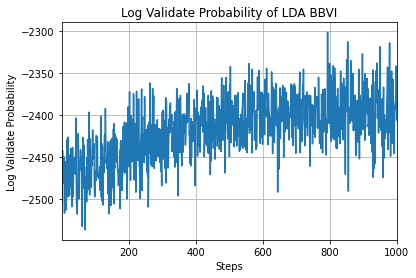

In [8]:
plt.plot(np.linspace(1, len(valid_prob), 
                     len(valid_prob)), valid_prob)
plt.title("Log Validate Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Validate Probability")
plt.grid()
plt.xlim((1, len(valid_prob)))

### 3.2 CAVI

We approximate the posterior distribution in the order level with distribution(guide) $q(\theta, \mathbf{z} | \gamma, \phi)$, where $\gamma$ is a $(K, 1)$ vector and $\phi$ is a $(N_i, K)$ matrix. Then, we use EM algorithm to estimate the $\alpha$ and $\beta$:

* (E-step) Find the optimal $\gamma^{*}_i$ and $\phi^{*}_i$ in each document.

* (M-step) Maximize the lower bound of likelihood $\mathcal{l}(\alpha, \beta) = \sum_{d=1}^{M} \log{p}(\mathbf{w}_d | \alpha, \beta)$ based on the parameters we got in the E-step.

The detailed derivation can be found in [1]. 

In [9]:
# model settings
num_topics = 5

# initialize the parameters
alpha = torch.rand(size=(num_topics, )) * 10
beta = torch.rand(size=(len(alpha), len(vocab))) 
beta /= beta.sum(-1).view(-1, 1)

# instantialize the cavi_obj
cavi_obj = LDACAVI(alpha, beta, 
                   corpora, num_topics,
                   num_particles=1)

In [ ]:
cavi_obj.reset_graph()

# Parameter estimation
alpha, beta = cavi_obj.estimate_params(
    train_data, tol=2e-3, show_step=50)

Compared to the ELBO of BBVI, the ELBO increase monotonously in CAVI algorithm.

(1.0, 160.0)

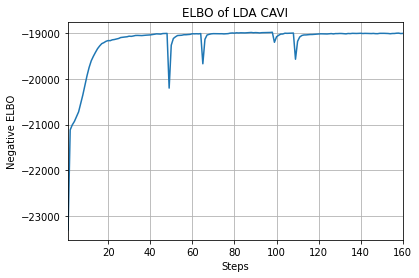

In [14]:
plt.plot(np.linspace(1, len(cavi_obj.trace_elbo), 
                     len(cavi_obj.trace_elbo)),
         cavi_obj.trace_elbo)
plt.title("ELBO of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Negative ELBO")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_elbo)))

## 4. Criticism

Observations:
* Looking at the volatility of BBVI's ELBO and Predictive Probability, it is clear that parameters (and thus model) are not stable.

* The raw values of BBVI's ELBO (60,000) is much worse than CAVI's (19,000), implying that CAVI's guide is much closer to the posterior.

To make sure that number of topics is not the issue here, we repeated 2 more iterations with different number of topics (2 and 8). The results are not too much bettter and the instability still persists.

In [ ]:
n_topics = 2
opt_params = {"lr": 0.005, "betas": (0.95, 0.999)}
n_steps = 500 # must be more than 20 steps
n_particles = 1

st = time.time()
bbvi_obj = LDABBVI(train_data, list(vocab), 
                   valid_data, ClippedAdam, opt_params,
                   n_topics)
e_eblo, log_prob, valid_prob = bbvi_obj.run_svi(
    n_steps=n_steps, num_particles=n_particles)
print(f"Takes {time.time() - st} seconds")

In [ ]:
n_topics = 8
opt_params = {"lr": 0.005, "betas": (0.95, 0.999)}
n_steps = 500 # must be more than 20 steps
n_particles = 1

st = time.time()
bbvi_obj_ = LDABBVI(train_data, list(vocab), 
                   valid_data, ClippedAdam, opt_params,
                   n_topics)
e_eblo_, log_prob_, valid_prob_ = bbvi_obj_.run_svi(
    n_steps=n_steps, num_particles=n_particles)
print(f"Takes {time.time() - st} seconds")

Text(0.5, 0.98, 'Negative ELBO of LDA BBVI')

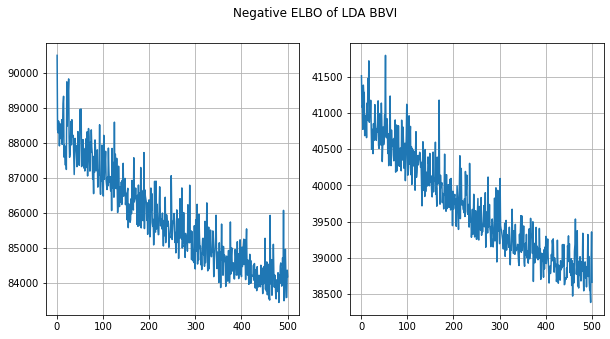

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(np.linspace(1, len(e_eblo_),
                     len(e_eblo_)), e_eblo_)
ax1.grid()
ax1.set_label("8 topics")
ax2.plot(np.linspace(1, len(e_eblo_),
                     len(e_eblo_)), e_eblo)
ax2.grid()
ax2.set_label("2 topics")
fig.suptitle("Negative ELBO of LDA BBVI")

(1.0, 500.0)

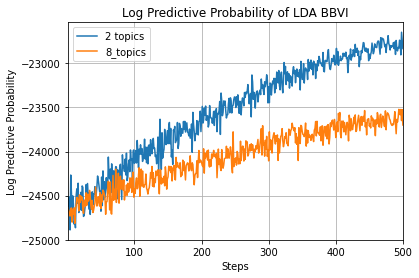

In [22]:
plt.plot(np.linspace(1, len(log_prob),
                     len(log_prob)), log_prob)
plt.plot(np.linspace(1, len(log_prob),
                     len(log_prob)), log_prob_)
plt.title("Log Predictive Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Predictive Probability")
plt.grid()
plt.legend(["2 topics", "8_topics"])
plt.xlim((1, len(log_prob)))

(1.0, 500.0)

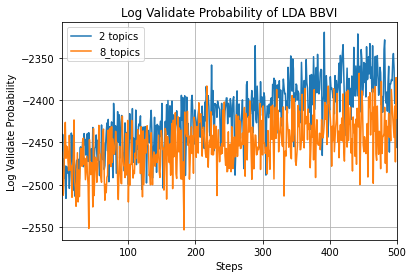

In [23]:
plt.plot(np.linspace(1, len(valid_prob_), 
                     len(valid_prob_)), valid_prob)
plt.plot(np.linspace(1, len(valid_prob_), 
                     len(valid_prob_)), valid_prob_)
plt.title("Log Validate Probability of LDA BBVI")
plt.xlabel("Steps")
plt.ylabel("Log Validate Probability")
plt.legend(["2 topics", "8_topics"])
plt.grid()
plt.xlim((1, len(valid_prob_)))

## 5. Analysis

#### Hypothesis: 
We initially hypothesized that BBVI failed because MC integration does not scale well with dimensions, which we have thousands of here (more than the number of total products). The converge rate of MC integral is $O(N^{-\frac{1}{D}})$ if we use $N$ particles in a $D$ dimensional space. 

Below is a toy example that shows the coefficient of variation (s.d./abs(mean)) of a few functions when dimensionality grows.

finished: 2 5 7 100 300 600 1000 

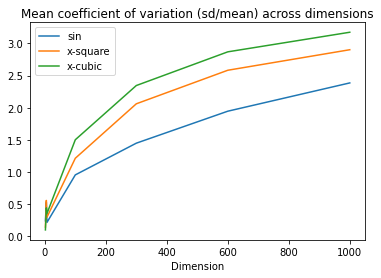

In [16]:
dims = [2, 5, 7, 100, 300, 600, 1000] 
q = dist.Dirichlet
funcs = [
    lambda x: np.sin(x),
    lambda x: np.power(x, 2),
    lambda x: np.power(x, 3),
]

run_mc_experiment(dims, funcs, q, n_trials=20, 
                  n_samples=100, 
                  func_names=["sin", "x-square", "x-cubic"])

However, we later discovered that Pyro's implementation included variance reduction techniques such as Rao-Blackwellization and control variates. After successfully using SVI on another simpler model also with 10,000 parameters, we decided that high-dimensional MC Integration is not itself a fatal problem.

This brings us to the next and final hypothesis...

### Updating thousands of parameters simultaneously

Since the number of parameters grows linearly with number latent variables, BBVI could be updating thousands of parameters simultaneously.

This is especially problematic when the parameters for topic assignments and topic weights can be very different in scale, since  they are parametrizing different distributions (Dirichlet vs. Multinomial). This makes estimates unstable for some parameters while optimizing others, which results in the following issues:
* Parameter could easily move out of a near-optimal region
* Difficult to pick a “one-size-fits-all” step size that ensures convergence of every parameters


CAVI avoids this by making use of mean-field assumption and optimizing each dimension individually.

## 6. Conclusions

* There are some inherent weaknesses of BBVI that makes it unsuitable for optimizing certain types of variational distributions. If we are using mean-field, we should make full use of the factorization of q(z) by using CAVI.


* We should have picked a better data set to test BBVI on. The average order size (less than 30) is suboptimal and might lead to issues in convergence and meaningful topic extraction with LDA[2]. Using a known data set where LDA works well on will more conclusively tell us the effectiveness of BBVI for LDA.

## 7. References

[1] Blei, David M.; Ng, Andrew Y.; Jordan, Michael I (January 2003) "Latent Dirichlet Allocation"

[2] Tang J, Meng Z, Nguyen XL, Mei Q, Zhang M (2014) “Understanding the limiting factors of topic modeling via posterior contraction analysis.”

[3] Ranganath, Rajesh, Sean Gerrish, and David Blei. (2014) “Black box variational inference.”